# Single-Network Models

To understand a network as an analytical object, we must clarify the set of behaviors (the *statistical properties*) we expect that the network might, reasonably, obey. In the case where we have a single network we wish to investigate, we call this set of properties the statistical model for a single network, or the single-network model, for short. The network is assumed to have $n$ vertices, with $n^2$ possible edges, and we are interested in conveying information about a hypothetical generative procedure that could produce a network with edges that behaves similarly to our own. These models are generative, in that we describe the properties of the observable data in the network, the edges and vertices, in a statistical way. For instance, consider a social network with $n$ people, where edges clarify whether a pair of people are connected on the social network. If we know nothing about any of the $n$ people, a reasonable model might be to simply expect that a pair of people are connected with some arbitrary probability, and that probability is identical for all of the possible pairs of people. On the other hand, if we know that $n/2$ of the people are in each of $2$ possible schools, we might anticipate that people within a school will have a higher probability of being connected than people between two schools. This distinction as to how we expect the network to be realized in practice is conveyed by the single-network model that is selected for further analysis. 

Before we get started, it is important to clarify that, as scientists, we must pay careful attention to an age old aphorism attributed to George Box, stating: "all models are wrong, but some are useful." In this sense, it is important to note that the statistical model selected is, in practice, virtually *never* the correct model. In the context of network statistics, this means that the generative model we select for our network will not be the true generative model that underlies our network. We will almost never have all of the information needed to convey the complex structure of a network; we may lack obvious things such as knowing every possible piece of information that governs whether a pair of vertices is connected or not, or we may not even believe that an edge is a realization of a stochastic process in the first place. Rather, we select a model which is appropriate from a family of candidate models on the basis of two primary factors:
1. The model possesses the level of refinement or complexity needed to answer our scientific question of interest, and 
2. The model is appropriate for the data we are given.

The remainder of this section will deal with developing intuition for 1., and a later selection on model selection will cover 2. 

## Erd&ouml;s-R&eacute;nyi (ER)

The simplest random network model is the Erd&ouml;s R&eacute;nyi (ER) model<sup>1</sup>. Consider the social network example explained above. If we do not know anything about how people may, or may not, be connected, the simplest possible thing to do with our network would be to assume that a given pair of people within our network have the same chance of being connected as any other selected pair of people. The $ER_n(p)$ model formalizes this relatively  situation with a single parameter:

1. $p$: an edge existence probability parameter governing how edges are connected.  

In words, a network with $n$ vertices which is supposed to be $ER_n(p)$ has thte property that each pair of vertices is connected with probability $p$, not connected with probability $1-p$, and that no other properties of the network (including which vertices an edge is incident, other edges within the graph, nor other factors) influence whether a pair of vertices are connected. Statistically, we write that for each edge $A_{ij}$, that $A_{ij}$ is sampled independently and identically from a $Bernoulli(p)$ distribution, for all $i, j$ from $1$ to $n$. The word "independent" clarifies that the occurence or not occurence of other edges in the network does not impact the probability of occurence of a given edge, and the word "identical" clarifies that the edge probability $p$ (or the probability of no edge, $1-p$) is the same for all edges within the network.

In practice, the $ER_n(p)$ model may seem too simple to be of practical value, but it holds a fundamental role in network statistical theory. Being simple, it is a straightforward exercise to compute many useful statistical properties of a network which is $ER_n(p)$. Consider, for instance, the vertex degree of an undirected graph, $deg(v_i) = \sum_{j \neq i}A_{ij}$. Computing the expected vertex degree of a vertex $v_i$ is a trivial exercise:
\begin{align*}
    \mathbb E[deg(v_i)] &= \mathbb E\left[\sum_{j \neq i} A_{ij}\right] \\
    &= \sum_{j \neq i} \mathbb E[A_{ij}]\;\;\;\;\textrm{Expectation of a finite sum is the sum of the expectations} \\
    &= (n-1) p
\end{align*}
Which follows by using the fact that all of the $n-1$ possible edges which are incident vertex $v_i$ have the same expected probability of occurence, $p$, governed by the parameter for the $ER_n(p)$ model. This tractability of theoretical results makes the $ER_n(p)$ an ideal candidate graph to study in describing properties of networks to be expected if the network is $ER_n(p)$. Similarly, we can easily invert the properties of $ER_n(p)$ networks, to study when a graph is *not* an $ER_n(p)$ random graph, and may merit more careful inferential tasks. On another front, when one wishes to devise new computational techniques and deduce the efficiency or effectiveness of a technique on a network with a given number of nodes and a given number of edges, and is not concerned with how efficient the technique is if the network displays other (potentially exploitable) properties, the $ER_n(p)$ model also makes a good candidate for analysis. This is particularly common when dealing with graphs which are known to be sparse; that is, $p$ is very small (usually, on the order or less than $1/n$).

The following python code can be used to generate and visualize a graph which is generated by the $ER_n(p)$ model. Here, we let $n=50$ vertices, and the probability of an edge $p=.3$:

<AxesSubplot:title={'center':'ER(50, 0.3) Simulation'}>

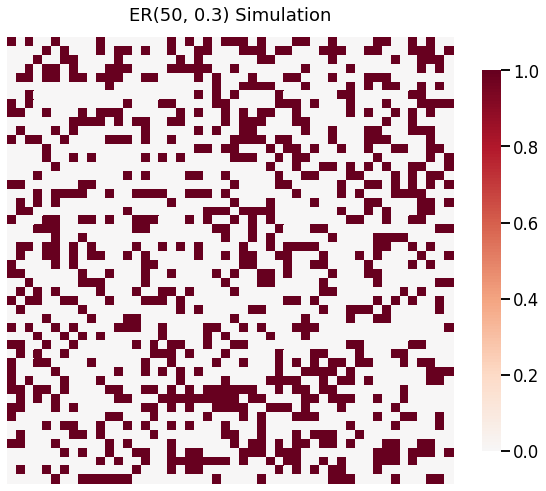

In [2]:
from graspologic.plot import heatmap
from graspologic.simulations import er_np

n = 50  # graph with 50 vertices
ps = 0.3  # probability of an edge existing is .3

# sample a single adj. mtx from ER(50, .3)
As = er_np(n=n, p=ps, directed=True, loops=True)

# and plot it
heatmap(As, title="ER(50, 0.3) Simulation")

In the simple simulation above, we sample a single, undirected, network with loops, with adjacency matrix $\pmb A^{(s)}$. We visualize the network using a heatmap, where we recall that a square is dark red if an edge is present, and white if no edge is present.

Given a graph with an adjacency matrix $\pmb A^{(s)}$, we can also use graspologic to estimate the probability parameter of the $ER_n(p)$ model:

In [3]:
from graspologic.models import EREstimator

# instantiate an ER Estimator which is directed with loops
er = EREstimator(directed=True, loops=True)
# fit an ER model to As
er.fit(As)
print(f"ER \"p\" parameter: {er.p_}")

ER "p" parameter: 0.3144


As we can see, the probability parameter for a directed network with loops is simply the average edge weight within the network:

In [4]:
print(f"Average edge weight: {As.mean()}")

Average edge weight: 0.3144


Which is in close agreement to the true probability, $p = 0.3$. When $p$ is larger, we might see something like the following:

<AxesSubplot:title={'center':'ER(50, 0.7) Simulation'}>

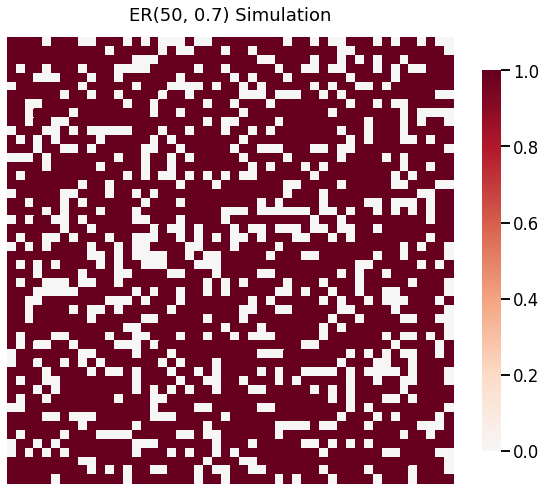

In [5]:
pl = 0.7  # graph has an edge probability of 0.7

# sample a single adj. mtx from ER(50, 0.7)
Al = er_np(n=n, p=pl, directed=True, loops=True)

# and plot it
heatmap(Al, title="ER(50, 0.7) Simulation")

As the edge existence probability increases, the sampled adjacency matrix tends to have more adjacencies with values of $1$. This is because there is a higher chance of an edge existing when $p$ is larger.

## Stochastic Block Model (SBM)

The Stochastic Block Model, or SBM, is a random graph model which produces graphs in which edge existence probabilities depend upon which vertices a given edge is adjacent to. If the graph $G = (\mathcal V, \mathcal E)$ is an SBM with $n$ vertices, each vertex $v_i$ can take be a member of one (and only one) of $K$ possible communities. In this case, rather than having a single edge existence probability, each pair of communities has its own unique edge existence probability. Formally, $G$ has the parameters:
1. $n$: the number of vertices,
2. $\vec \tau \in \{1, ..., K\}^n$: the vertex assignment vector for each of the $n$ vertices to one of $K$ communities, and
3. $\pmb B \in [0, 1]^{K \times K}$: the symmetric edge existence probability for each of the $K \times K$ possible communities.

The vertex assignment vector has entries $\vec \tau_i$, where $i = 1, ..., n$, for each of the vertices in the graph. For a given vertex $v_i \in \mathcal V$, the corresponding vertex assignment $\vec \tau_i$ defines which of the $K$ communities in which $v_i$ is a member. For instance, in a social network in which the vertices are students and the edges define whether two students are friends, a vertex assignment vector might denote the school in which each student learns. The matrix $\pmb B$ with entries $b_{kl}$ for $k, l = 1,..., K$ defines the probability of an edge existing between vertices which are in community $k$ with vertices which are in community $l$. For instance, in the social network example, one might select $\pmb B$ such that the diagonal entries $b_{kk}$ for $k = 1,..., K$ tend to exceed off-diagonal entries $b_{kl}$ where $k \neq l$ and $k,l = 1,...,K$. Further, the matrix $\pmb B$ is supposed to be symmetric; that is, for any $b_{kl}$, it is always the case that $b_{k,l} = b_{lk}$ for all $k = 1,..., K$. Intuitionally, this would correspond to the graph in which each of the  The matrix $\pmb B$ defines that if vertex $v_i$ is in community $k$ and vetex $v_j$ is in community $l$, then an edge $e_{ij}$ or $e_{ji}$ exists between $v_i$ and $v_j$ with probability $b_{kl}=b_{lk}$. Fomally, we wite that $\pmb A \sim SBM_n(\vec \tau, \pmb B)$ if $A_{ij} | v_i = k, v_j = l \sim Bernoulli(b_{kl})$, or equivalently due to the symmetry of $\pmb B$, $A_{ji} | v_i = k, v_j = l \sim Bernoulli(b_{kl})$, for all $i,j \in 1,...,n$.

The following python code can be used to generate and visualize the adjacency matrices describing a graph which has the $SBM_n(\vec \tau, \pmb B)$ distribution.

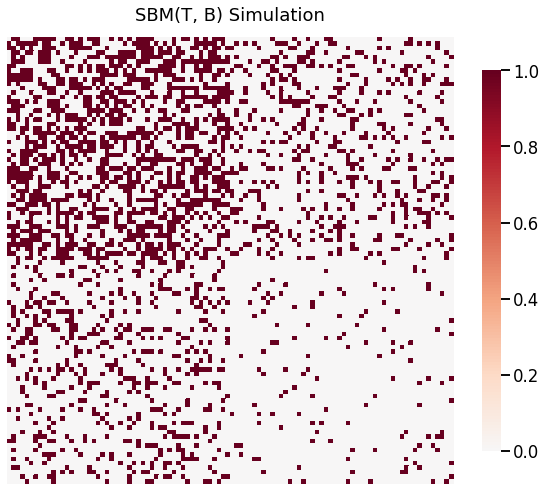

In [7]:
from graspologic.simulations import sbm

# for simplicity, the simulation code generates samples wherein
# vertices from the same community are ordered in the vertex set by
# their community order. Note that it would be theoretically equivalent to
# denote the total number of vertices in each community, or provide
# a vector tau with the first 50 entries taking the value 1, and the
# second 50 enties taking the value 0, given this fact.
ns = [50, 50]
n = sum(ns)

n = sum(ns)  # total number of vertices is the sum of the 
B = [[.5, .2],
    [.2, .05]]

A = sbm(n=ns, p=B)
_=heatmap(A, title="SBM(T, B) Simulation")

In the above simulation, we can clearly see an apparent $4$-"block structure", which describes the fact that the probability of an edge existing depends upon which of the $4$ "blocks" the edge falls into. These blocks are the apparent "subgraphs", or square patterns, observed in the above graph. The block structure is clearly delineated by the first $50$ vertices being from a single community, and the second $50$ vertices being from a different community.

It is important to note that a graph may be $SBM_n(\vec \tau, \pmb B)$ regardless of whether a block structure is visually discernable. Indeed, the block structure may only be apparent given a particular ordering of the vertices, an otherwise, may not even be discernable at all. Consider, for instance, a similar adjacency matrix to the graph plotted above, with the exact same realization, up to a permutation (reordering) of the vertices. The below graph shows the exact same set of adjacencies as-above, but wherein $\pmb A$ has had its vertices resorted randomly. The graph has an identical block structuure (up to the reordering of the vertices) as the preceding graph illustrated.

<ipython-input-11-8581568507e8>:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  heatmap(A[[vtx_perm]] [:,vtx_perm])


<AxesSubplot:>

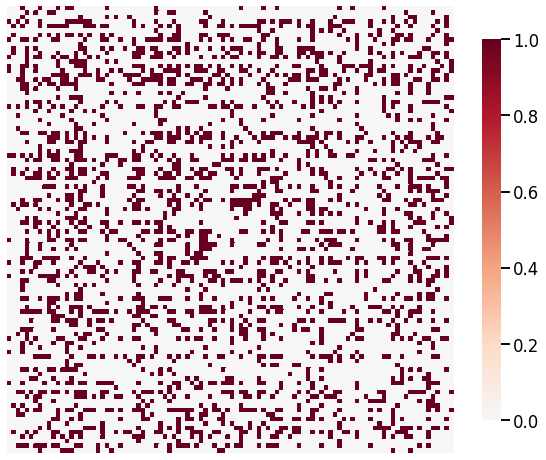

In [11]:
import numpy as np

# generate a permutation of the n vertices
vtx_perm = np.random.choice(n, size=n, replace=False)

# same adjacency matrix (up to reorder of the vertices)

heatmap(A[[vtx_perm]] [:,vtx_perm])

In this sense, it becomes quite difficult in practice to determine whether community structure exists simply by looking at a graph, unless you are looking at a graph in which the vertices are already arranged in an order which respects the community struucture. 

## Structured Independent Edge Model (SIEM)

## Random Dot Product Graph (RDPG)

## Generalized Random Dot Product Graph (GRDPG)

## Degree-Corrected Models

## Inhomogeneous Erdos-Renyi (IER)

# References

[1] Erd&ouml;s P, R&eacute;nyi A. 1959. "On random graphs, I." Publ. Math. Debrecen 6:290–297.
